# Capstone 2 Project: CDC Nutrition Exam 2013-2014

### Audience: General
#### Problem:
The purpose of this project is to analyze what health choices lead specifically to outcomes such as weight, bmi, proclivity to disease, etc. The data for this project was gathered from the 2013-2014 National Health and Nutrition Examination Survey (NHANES - for quick access click [here](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=diet.csv)). Although this resource had a lot of great data related to all sorts of different aspects of physiology and health, most of it is outside of the scope of this project and will thus be filtered out.

## Part 1: Data Wrangling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassificationReport

import warnings
warnings.filterwarnings('ignore')

In [2]:
demographic = pd.read_csv('my_data/demographic.csv')
diet = pd.read_csv('my_data/diet.csv')
examination = pd.read_csv('my_data/examination.csv')

In [3]:
dem_my_col = ['SEQN', 'RIAGENDR', 'RIDAGEYR']
dem_col_name = ['Seq_Number', 'Gender', 'Age_yr']
demographic = demographic.filter(dem_my_col, axis=1)
demographic.columns = dem_col_name
demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10175 entries, 0 to 10174
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Seq_Number  10175 non-null  int64
 1   Gender      10175 non-null  int64
 2   Age_yr      10175 non-null  int64
dtypes: int64(3)
memory usage: 238.6 KB


In [4]:
diet_my_col = ['SEQN','DR1TNUMF','DR1TKCAL','DR1TPROT','DR1TCARB','DR1TSUGR','DR1TFIBE','DR1TTFAT']
diet_col_name = ['Seq_Number', '#_diff_foods', 'tot_calories', 'total_protein', 'total_carb', 'total_sugar', 'total_fiber','total_fat']

diet = diet.filter(diet_my_col, axis=1)
diet.columns = diet_col_name
diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Seq_Number     9813 non-null   int64  
 1   #_diff_foods   8661 non-null   float64
 2   tot_calories   8531 non-null   float64
 3   total_protein  8531 non-null   float64
 4   total_carb     8531 non-null   float64
 5   total_sugar    8531 non-null   float64
 6   total_fiber    8531 non-null   float64
 7   total_fat      8531 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 613.4 KB


In [5]:
exam_my_col = ['SEQN', 'BPXSY1', 'BPXSY2', 'BPXSY3','BMDAVSAD','BMXBMI', 'BMXWAIST', 'BMXWT']
exam_col_name = ['Seq_Number', 'BP_1', 'BP_2', 'BP_3', 'avg_visc_fat', 'bmi', 'waist', 'weight']


examination = examination.filter(exam_my_col, axis=1)
examination.columns = exam_col_name
examination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Seq_Number    9813 non-null   int64  
 1   BP_1          7172 non-null   float64
 2   BP_2          7409 non-null   float64
 3   BP_3          7408 non-null   float64
 4   avg_visc_fat  7218 non-null   float64
 5   bmi           9055 non-null   float64
 6   waist         8661 non-null   float64
 7   weight        9723 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 613.4 KB


In [6]:
dem_diet = pd.merge(demographic, diet, how="outer",on='Seq_Number')
df = pd.merge(dem_diet, examination, how="outer",on='Seq_Number')
df.head()

,Seq_Number,Gender,Age_yr,#_diff_foods,tot_calories,total_protein,total_carb,total_sugar,total_fiber,total_fat,BP_1,BP_2,BP_3,avg_visc_fat,bmi,waist,weight
0,73557,1,69,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,122.0,114.0,102.0,20.6,26.7,100.0,78.3
1,73558,1,54,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,156.0,160.0,156.0,24.4,28.6,107.6,89.5
2,73559,1,72,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,140.0,140.0,146.0,25.6,28.9,109.2,88.9
3,73560,1,9,19.0,1490.0,77.75,162.92,80.58,10.6,58.27,108.0,102.0,104.0,14.9,17.1,61.0,32.2
4,73561,2,73,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,136.0,134.0,142.0,NaN,19.7,NaN,52.0


The above cells were utilized to pull in our dataframe from all of the csv files with pertinent information that we wanted. Below we will impute missing values so that we can have as complete data as possible.

In [7]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Seq_Number,0,0.000000
Gender,0,0.000000
Age_yr,0,0.000000
weight,452,4.442260
bmi,1120,11.007371
waist,1514,14.879607
#_diff_foods,1514,14.879607
tot_calories,1644,16.157248
total_protein,1644,16.157248
total_carb,1644,16.157248


In [8]:
df.dropna(subset=['tot_calories'], inplace=True)

In [9]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Seq_Number,0,0.000000
total_fat,0,0.000000
total_sugar,0,0.000000
total_carb,0,0.000000
total_protein,0,0.000000
total_fiber,0,0.000000
#_diff_foods,0,0.000000
Age_yr,0,0.000000
Gender,0,0.000000
tot_calories,0,0.000000


As none of our features have normal distributions, we will go ahead and impute the remaining missing values with the median for each feature

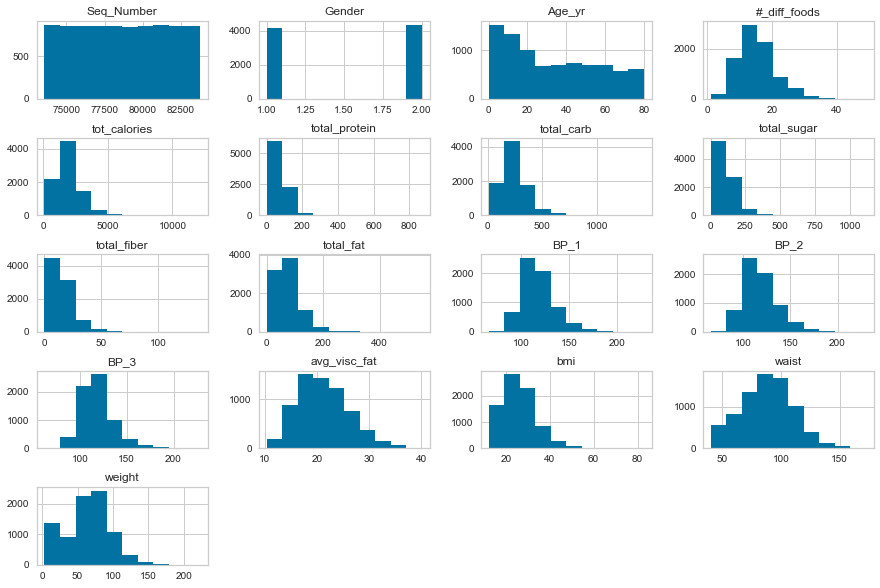

In [10]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [11]:
set_median = ['weight','waist', 'bmi', 'BP_3', 'BP_2', 'BP_1', 'avg_visc_fat']

def null_set_med(dataframe, list):
    for item in list:
       dataframe.loc[df[item].isnull(), item] = df[item].median()

null_set_med(df, set_median)

In [12]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Seq_Number,0,0.0
bmi,0,0.0
avg_visc_fat,0,0.0
BP_3,0,0.0
BP_2,0,0.0
BP_1,0,0.0
total_fat,0,0.0
waist,0,0.0
total_fiber,0,0.0
total_carb,0,0.0


Now that our missing values are taken care of, I want to further manipulate the dataframe by combining columns, converting some columns into more readable terms, and generally prepare to model the data

In [13]:
#Combining the Blood Pressure columns into a single feature
df['ave_BP'] = (df[['BP_1', 'BP_2', 'BP_3']].sum(axis=1)/3)
#Creating Binary fields if subject was adult
df['adult'] = 1
df.loc[df['Age_yr'] <= 18, 'adult'] = 0
#Creating Binary Feature to Assess off of
df['obese'] = 0
df.loc[df['bmi'] >= 30, 'obese'] = 1
#Switching Gender from 1-2 to 0-1
df.loc[df['Gender'] == 1, 'Gender'] = 0
df.loc[df['Gender'] == 2, 'Gender'] = 1
#Switching from metric to U.S. measurements
df['weight'] = df['weight'] * 2.205
df['waist'] = df['waist'] / 2.54
#Dropping all unnecessary fields at this point based off of our data manipulation
df = df.drop(columns=['BP_1', 'BP_2', 'BP_3','bmi','Seq_Number'])

df.head()

,Gender,Age_yr,#_diff_foods,tot_calories,total_protein,total_carb,total_sugar,total_fiber,total_fat,avg_visc_fat,waist,weight,ave_BP,adult,obese
0,0,69,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,20.6,39.370079,172.6515,112.666667,1,0
1,0,54,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,24.4,42.362205,197.3475,157.333333,1,0
2,0,72,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.6,42.992126,196.0245,142.000000,1,0
3,0,9,19.0,1490.0,77.75,162.92,80.58,10.6,58.27,14.9,24.015748,71.0010,104.666667,0,0
4,1,73,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,20.8,34.881890,114.6600,137.333333,1,0


Rows, Columns:  (8531, 15)


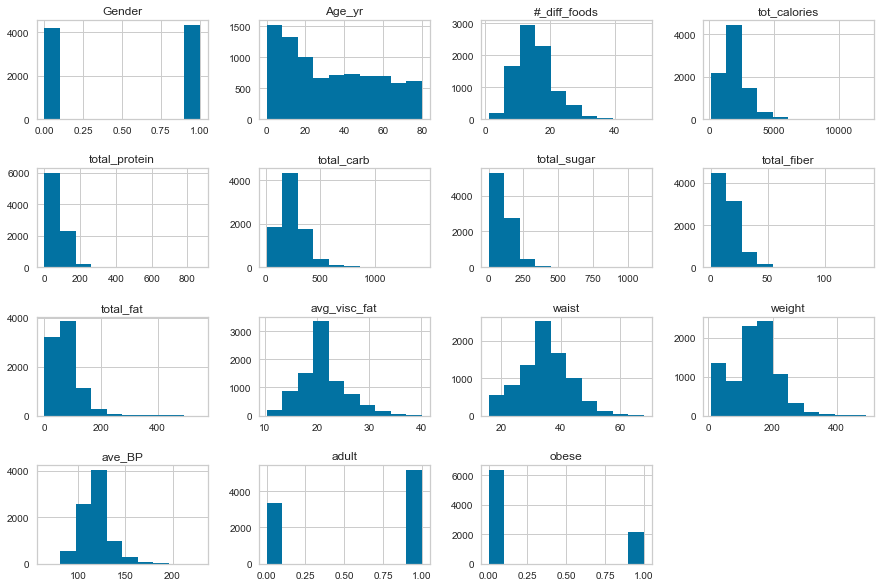

In [14]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
print('Rows, Columns: ', df.shape)

## Part 2:  Exploratory Data Analysis

(array([1.357e+03, 9.010e+02, 2.304e+03, 2.423e+03, 1.079e+03, 3.310e+02,
        8.700e+01, 3.800e+01, 9.000e+00, 2.000e+00]),
 array([  7.2765 ,  55.63215, 103.9878 , 152.34345, 200.6991 , 249.05475,
        297.4104 , 345.76605, 394.1217 , 442.47735, 490.833  ]),
 <BarContainer object of 10 artists>)

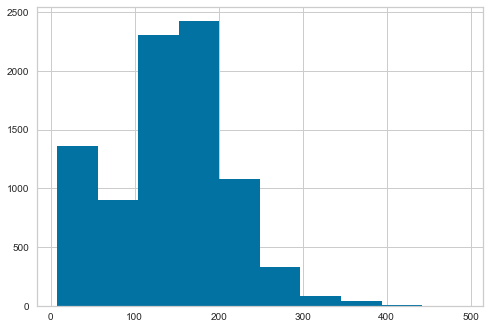

In [15]:
plt.hist(df['weight'])

In [16]:
print(df['weight'].describe())
print("# different values: ",len(df['weight'].value_counts()))

count    8531.000000
mean      142.735199
std        69.564598
min         7.276500
25%        99.004500
50%       147.955500
75%       186.984000
max       490.833000
Name: weight, dtype: float64
# different values:  1358


<AxesSubplot:>

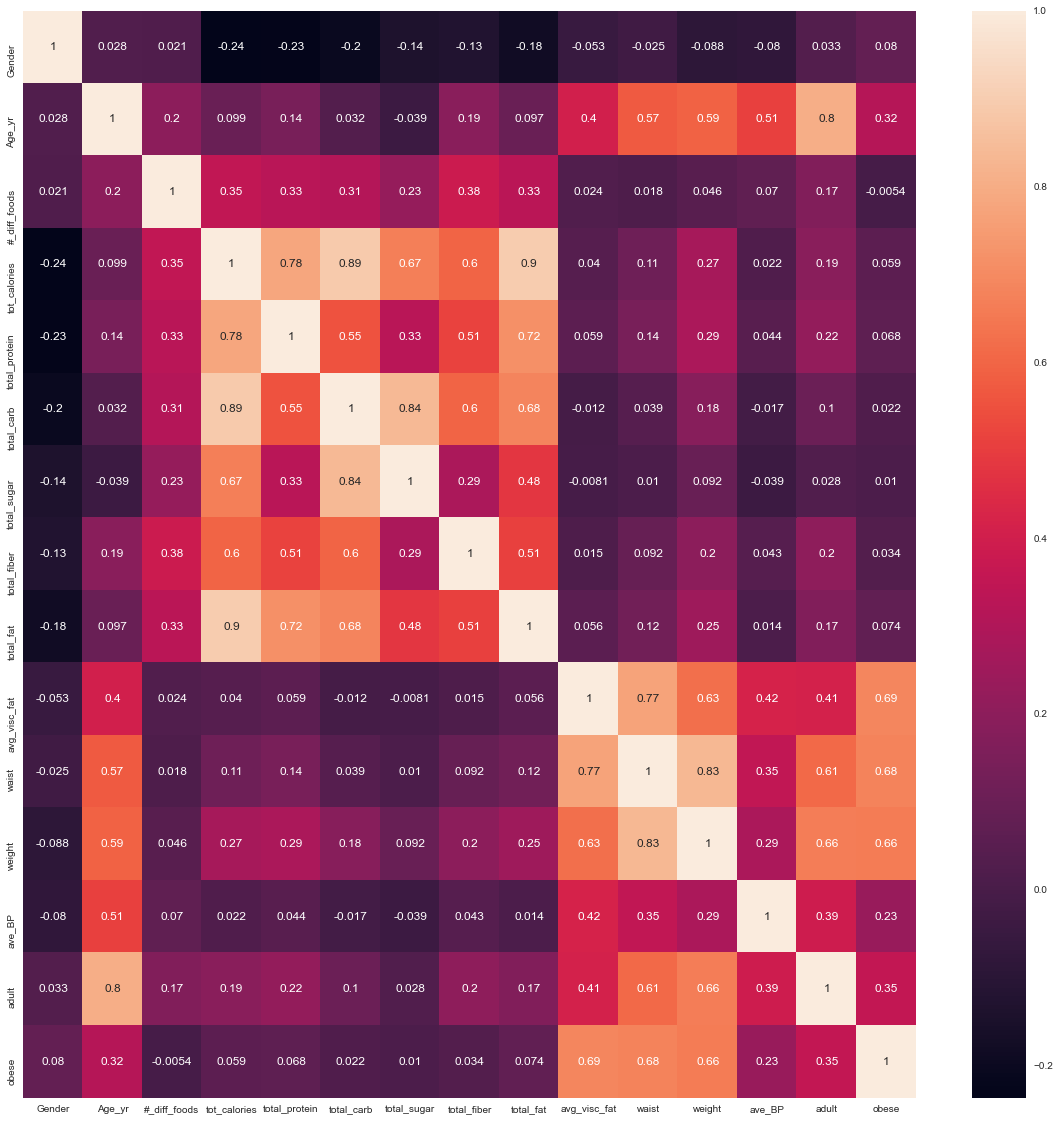

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)

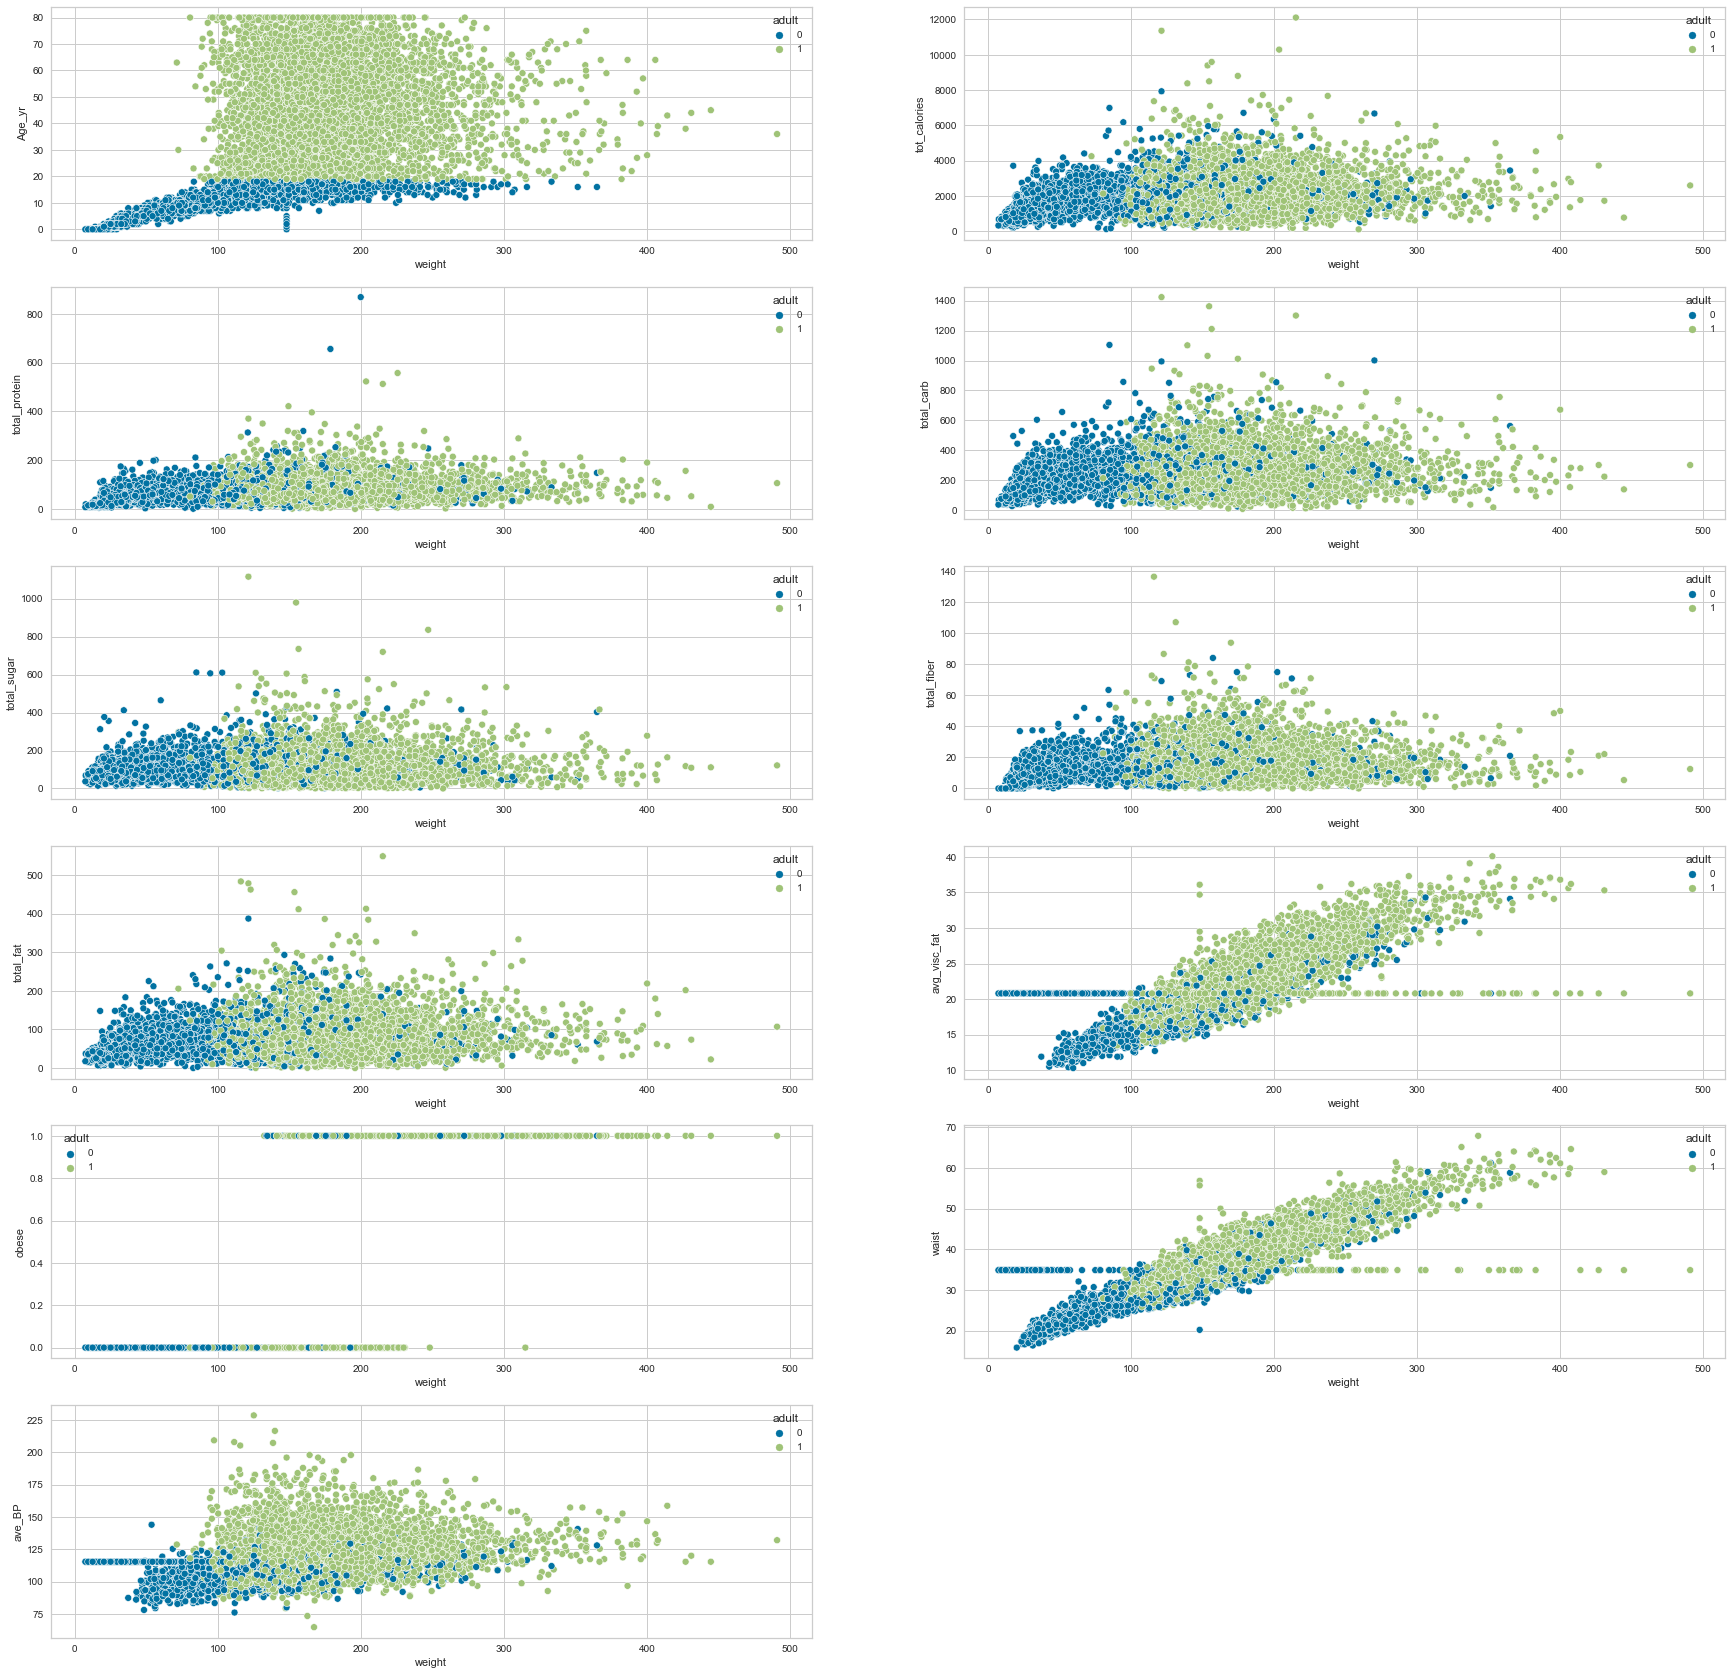

In [18]:
my_cols = ['Age_yr', 'tot_calories', 'total_protein',
       'total_carb', 'total_sugar', 'total_fiber', 'total_fat',
        'avg_visc_fat', 'obese', 'waist', 'ave_BP']

def my_subplots(plot_type,x_value, y_list,hue):
    plt.figure(figsize=(30,30))
    for i in range(len(y_list)):
        plt.subplot(round(len(y_list)/2),2,(i+1))
        plot_type(x=x_value, y=y_list[i],hue=hue,data=df)

my_subplots(sns.scatterplot,'weight', my_cols, 'adult')

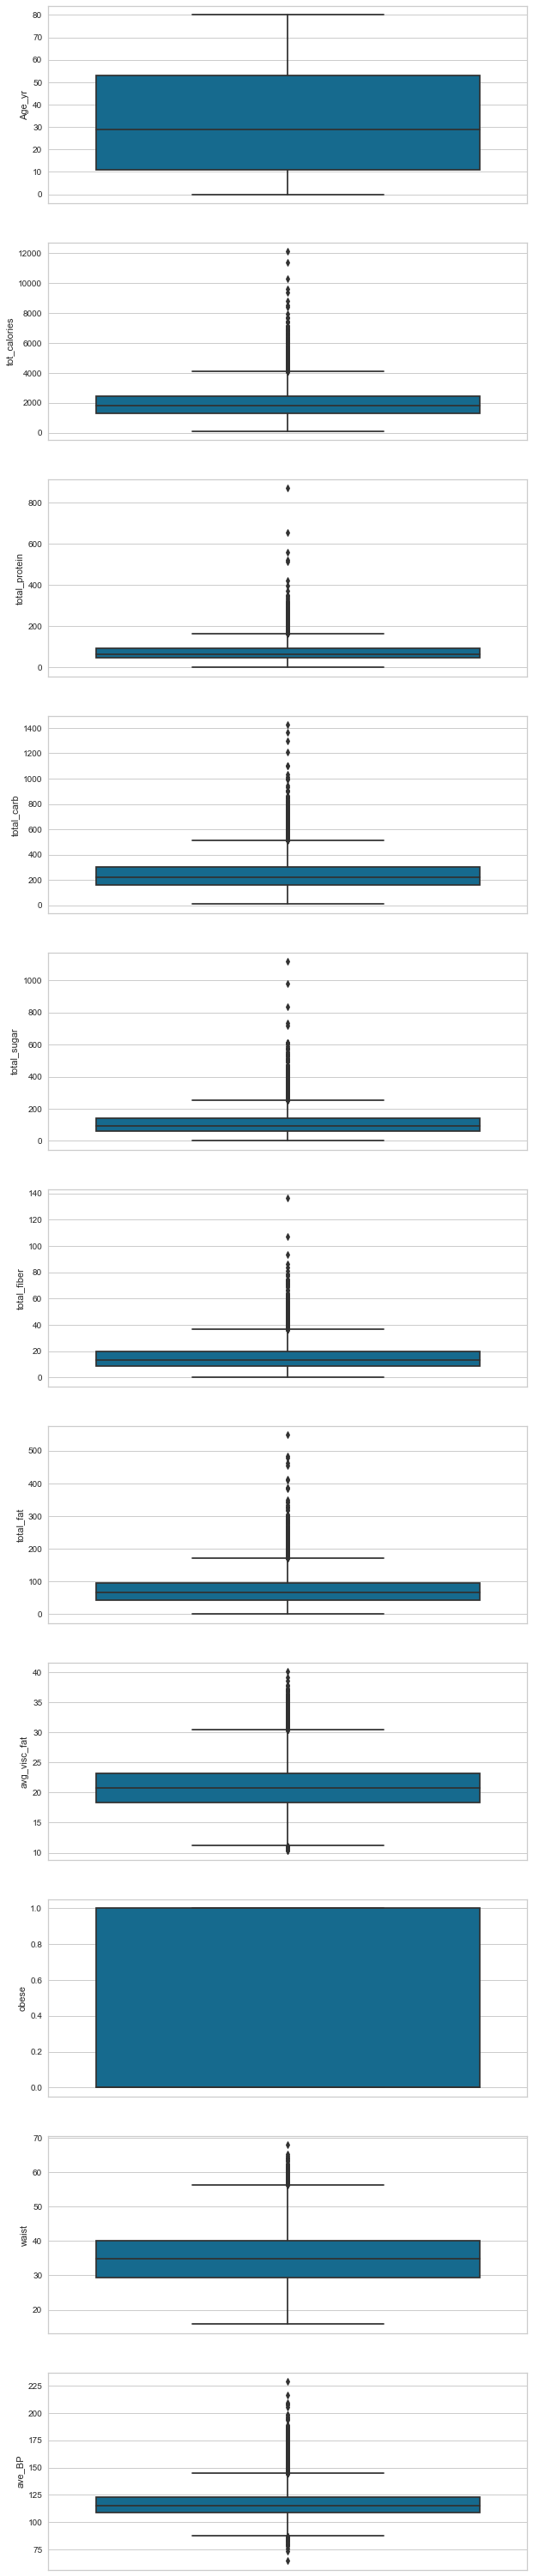

In [19]:
def my_boxplot(cols):
    plt.figure(figsize=(10,len(cols) *5))
    for i in range(len(cols)):
        plt.subplot(len(cols),1,(i+1))
        sns.boxplot(y=cols[i],data=df)

my_boxplot(my_cols)

## Part 3: Preprocessing

##### Client Scenario:
After finishing with the assessment, David Greene (subject 8513) approached his physician and asked about some potential scenarios about how he might go about losing weight. he knows that he should be more careful about the food that he eats, but with all of the mixed messages he gets about nutrition, he doesn't know where to start. He has heard a lot of information about different eating styles such as Intermittent Fasting, Low-Carb (Ketogenic Diet), and Low-Fat and is wondering if any of those diets might help. He also has a good friend, Gerald (subject 8 - who also took the assessment, was in the same demographic, and looked to be in good health) that says that he could give him some pointers and suggested that he model his lifestyle after him. David is wondering which line of action to take.

To know whether the course of action is successful, we will model off of whether the bmi of the subject falls into a healthier range (No longer obese or BMI is less than 30)

In [20]:
#Here we are pulling out our client
David_G = pd.DataFrame(df.iloc[8513]).T.drop(columns=["obese"])
df = df.drop(labels=8513, axis=0)

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["obese"])
y = df.obese == 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 4: Modeling

Here we will find which classification model will output the most accurate results so that we can best help David lead a healthier lifestyle

In [23]:
def display_score_results(model):
    visualizer = ClassificationReport(model, classes=[1,0], support=True)

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show() 
    
    
    cv_scores_test= cross_val_score(model,X_test,y_test,cv=5,scoring='roc_auc')
    cv_scores_train= cross_val_score(model,X_train,y_train,cv=5,scoring='roc_auc')
    print("5-fold CV Scores: ", cv_scores_test)
    print ('Mean testing score: ', cv_scores_test.mean())
    print ('Mean training score: ', cv_scores_train.mean())
    print ('Standard deviation: ', cv_scores_test.std())

###### Random Forest

[[1218   43]
 [  74  371]]
0.9314185228604924


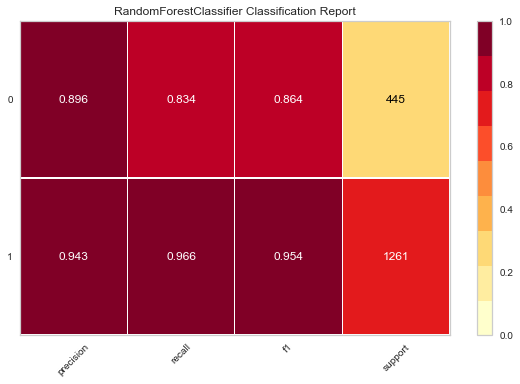

5-fold CV Scores:  [0.9824799  0.98013644 0.98412698 0.96698324 0.97899946]
Mean testing score:  0.9785452049985512
Mean training score:  0.9831183603327489
Standard deviation:  0.006050712847393196


In [24]:
rf = RandomForestClassifier(bootstrap=True,n_estimators=100,criterion='entropy')
rf.fit(X_train, y_train)

y_predict_rf = rf.predict(X_test)

print(confusion_matrix(y_test, y_predict_rf))
print(rf.score(X_test,y_test))
display_score_results(rf)

###### K-Nearest Neighbor

[[1237   24]
 [ 133  312]]
0.9079718640093787


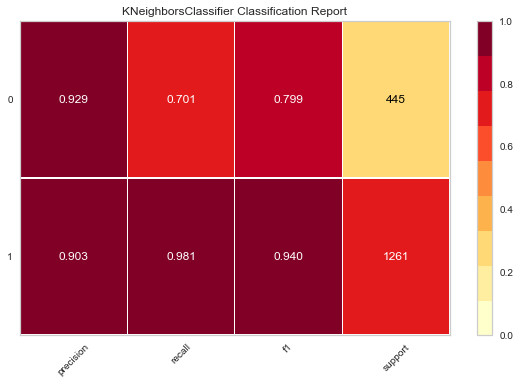

5-fold CV Scores:  [0.97002265 0.96531122 0.97743892 0.96161049 0.96098627]
Mean testing score:  0.9670739074744936
Mean training score:  0.9754213555606854
Standard deviation:  0.0061015387714469325


In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(p=2,weights='distance',n_neighbors=50)
knn.fit(X_train,y_train)

y_predict_knn=knn.predict(X_test)

print(confusion_matrix(y_test, y_predict_knn))
print(knn.score(X_test,y_test))
display_score_results(knn)

###### Support Vector Machine

[[1221   40]
 [  81  364]]
0.929073856975381


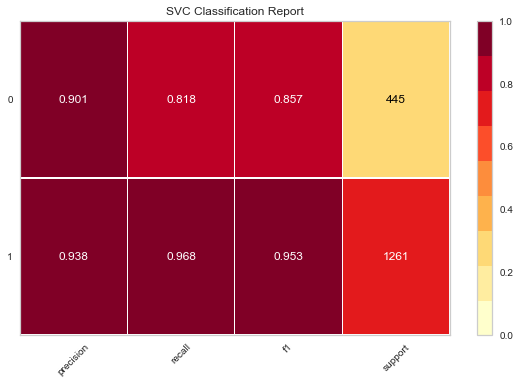

5-fold CV Scores:  [0.98103655 0.98073836 0.98894239 0.96562333 0.97980203]
Mean testing score:  0.9792285335030817
Mean training score:  0.9844488669503505
Standard deviation:  0.007554311385645041


In [26]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_predict_svm=svm.predict(X_test)

print(confusion_matrix(y_test, y_predict_svm))
print(svm.score(X_test,y_test))
display_score_results(svm)

###### Gradient Boosting

[[1208   53]
 [  75  370]]
0.9249706916764361


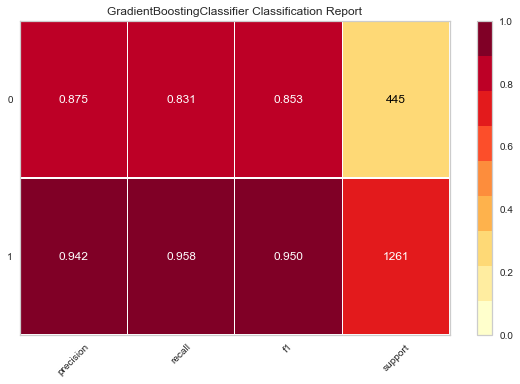

5-fold CV Scores:  [0.98272416 0.97917781 0.98220974 0.96348315 0.9778402 ]
Mean testing score:  0.9770870122115847
Mean training score:  0.9833643726050614
Standard deviation:  0.0070430634382236046


In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.05 , n_estimators=160, random_state=5, max_depth=9, max_leaf_nodes=100)
gbc.fit(X_train, y_train)

y_predict_gbc = gbc.predict(X_test)

print(confusion_matrix(y_test, y_predict_gbc))
print(gbc.score(X_test,y_test))
display_score_results(gbc)

###### Naive Bayes

[[1084  177]
 [  57  388]]
0.8628370457209847


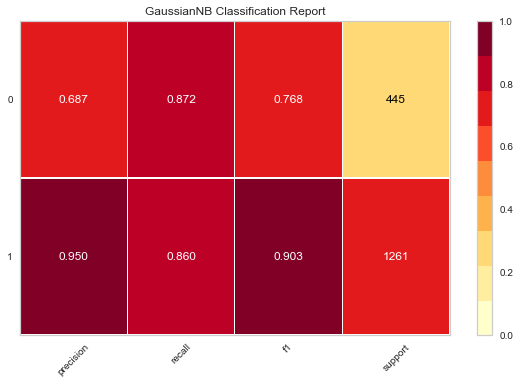

5-fold CV Scores:  [0.94843896 0.92634207 0.95853398 0.92442483 0.94480114]
Mean testing score:  0.9405081945140568
Mean training score:  0.9495573314284581
Standard deviation:  0.013157575166622791


In [28]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train,y_train)

y_predict_nb=nb.predict(X_test)

print(confusion_matrix(y_test, y_predict_nb))
print(nb.score(X_test,y_test))
display_score_results(nb)

## Part 5: Implementation of Model
It appears that the Random Forest model Performed the best, so that will be the model that we utilize. We will utilize the model by replacing Davids current behavior and lifestyle with behavior reminiscent of the lifestyles that he asked his physician about

In [35]:
#This function is meant to take features for our client and replace the current values he has with new values and determine
#if that would lead him to a healthy weight

def predict_when_replaced(features, replacements):
    dg2 = David_G.copy()
    for f, r in zip(features, replacements):
        dg2[f] = r
    return rf.predict(dg2).item()

##This Function will print out what the expected results would be based off of the proposed changes
def print_proposed_changes(replace_features,replace_values):
    if predict_when_replaced(replace_features,replace_values) == True:
        print('Congratulations! making the following lifestyle changes will lead you to a healthy weight!')
        for i in range(len(replace_features)):
            print(f'\t Changing {replace_features[i]} from {David_G[replace_features[i]].item()} to {replace_values[i]}')
    else:
        print('The following WAS NOT enough to make a healthy weight. more change is required')
        for i in range(len(replace_features)):
            print(f'\t Changing {replace_features[i]} from {David_G[replace_features[i]].item()} to {replace_values[i]}')


In [36]:
David_G

,Gender,Age_yr,#_diff_foods,tot_calories,total_protein,total_carb,total_sugar,total_fiber,total_fat,avg_visc_fat,waist,weight,ave_BP,adult
10151,0.0,64.0,8.0,2383.0,92.38,358.11,193.42,15.6,70.85,36.5,62.047244,386.316,96.666667,1.0


###### Scenario 1: Implementing friends lifestyle

In [37]:
replace_features = ['tot_calories','total_fat','total_sugar']
replace_values = [2021,82.95,98]
#,38.09,116,98,7.0,100,0,20,10
print_proposed_changes(replace_features,replace_values)

Congratulations! making the following lifestyle changes will lead you to a healthy weight!
	 Changing tot_calories from 2383.0 to 2021
	 Changing total_fat from 70.85 to 82.95
	 Changing total_sugar from 193.42 to 98


###### Scenario 2: Low-Fat Diet

In [38]:
replace_features = ['tot_calories','total_carb','total_sugar','total_fat']
replace_values = [2600,400,220,10]
print_proposed_changes(replace_features,replace_values)

Congratulations! making the following lifestyle changes will lead you to a healthy weight!
	 Changing tot_calories from 2383.0 to 2600
	 Changing total_carb from 358.11 to 400
	 Changing total_sugar from 193.42 to 220
	 Changing total_fat from 70.85 to 10


###### Scenario 3: IF/Keto - Low-Carb

In [39]:
replace_features = ['tot_calories','total_protein','total_carb','total_sugar','total_fat']
replace_values = [1500,100,50,0,300]
print_proposed_changes(replace_features,replace_values)

Congratulations! making the following lifestyle changes will lead you to a healthy weight!
	 Changing tot_calories from 2383.0 to 1500
	 Changing total_protein from 92.38 to 100
	 Changing total_carb from 358.11 to 50
	 Changing total_sugar from 193.42 to 0
	 Changing total_fat from 70.85 to 300


##### Conslusion: Our Datas Story

as is shown above, the scenarios that succeeded were the scenarios in which Davids dietary fat was increased and carbohydrates (particularly sugars) was drastically cut. There are many reasons for this but the main reasons stem from the simplified model below that shows what happens in relation to when our blood glucose increases and decreases:

Our bodies try and avoid two conditions related to blood glucose called Hyperglycemia and Hypoglycemia. Everytime we eat our blood glucose rises. This is beneficial to our bodies as our cells can grab the glucose and eventually produce ATP and make energy. However, our cells can only take so much and so our pancreas' secrete a hormone called Insulin which will take the leftover glucose in the blood and store it as glycogen in the muscles and liver. If there is even more after that, then our pancreas will proceed to secrete insulin and eventually the leftover glucose will get converted into fat and stored in adipose tissue. This is where the other hormone secreted by the pancreas comes into play. This hormone is called Glucagon, and the pancreas will secrete this hormone only when there is a severe lack of blood glucose. This is the hormone that is in charge of pulling the stored glycogen out of the muscles and liver and even eventually, directly out of the fat cells. Because of this, any time that insulin is being secreted it means in turn that glucagon is not being secreted and the fat molecules are stuck in the adipose tissue and trapped by an enzyme known as hormone sensitive lipase.

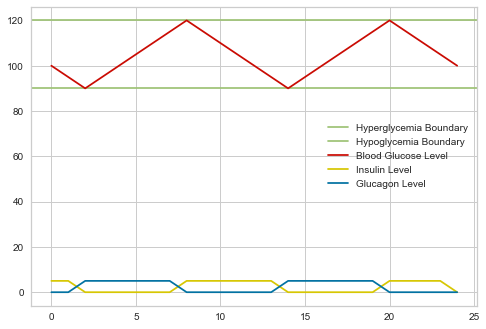

In [40]:
def plot_hormone_levels():
    time = [x for x in range(24)]
    blood_glucose = [100]
    insulin = []
    glucagon = []
    hyper = True
    hypo = False
    for t in time:
        if blood_glucose[t] >= 120:
            hyper = True
            hypo = False
        if blood_glucose[t] <= 90:
            hyper = False
            hypo = True
        if hyper:#blood glucose is too high and pancreas needs to secrete insulin
            insulin.append(5)
            glucagon.append(0)
            blood_glucose.append(blood_glucose[t] + glucagon[t] - insulin[t])
        if hypo:#blood glucose is too low and pancreas needs to secrete glucagon
            glucagon.append(5)
            insulin.append(0)
            blood_glucose.append(blood_glucose[t] + glucagon[t] - insulin[t])
        
       # print(f'{t}: hyper crossed? {hyper} -- hypo crossed? {hypo}')
        
    insulin.append(0)
    glucagon.append(0)
    time.append(time[-1]+1)
    
    #print(f'Time: {time} -- {len(time)} \nBlood Glucose: {blood_glucose} -- {len(blood_glucose)}\nInsulin: {insulin} -- {len(insulin)}\nGlucagon: {glucagon} -- {len(glucagon)}')
    
    plt.axhline(y=120,color='g',linestyle='-')
    plt.axhline(y=90,color='g',linestyle='-')
    plt.plot(time, blood_glucose, color='r')
    plt.plot(time, insulin, color='y')
    plt.plot(time, glucagon, color='b')
    plt.legend(['Hyperglycemia Boundary', 'Hypoglycemia Boundary', 'Blood Glucose Level', 'Insulin Level', 'Glucagon Level'])
    plt.show()  

            
    
    
plot_hormone_levels()

So this simplified visualization shows that when blood glucose becomes more concentrated, then insulin is secreted and glucagon production stops, and as soon as there is an absence of blood glucose and we start approaching hypoglycemia, then our pancreas will switch over to glucagon production which will pull stored energy from our body. If David were to approach the weight loss problem like this and drastically cut his sugar intake, then his body would have the time to slip into glucagon secretion and all of that stored body fat that he has probably dragged around for years will start to literally melt off of him.